/Users/annamironovich/anaconda3/envs/basic/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       399
           1       0.61      0.80      0.69       326
           2       0.87      0.63      0.73       339
           3       0.91      0.78      0.84       309
           4       0.97      0.83      0.90       311
           5       0.86      0.87      0.87       292
           6       0.82      0.92      0.87       266

    accuracy                           0.79      2242
   macro avg       0.82      0.80      0.80      2242
weighted avg       0.81      0.79      0.80      2242

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       176
           1       0.61      0.77      0.68       157
           2       0.80      0.65      0.72       140
           3       0.92      0.79      0.85       114
           4       0.96      0.77      0.85       115
    

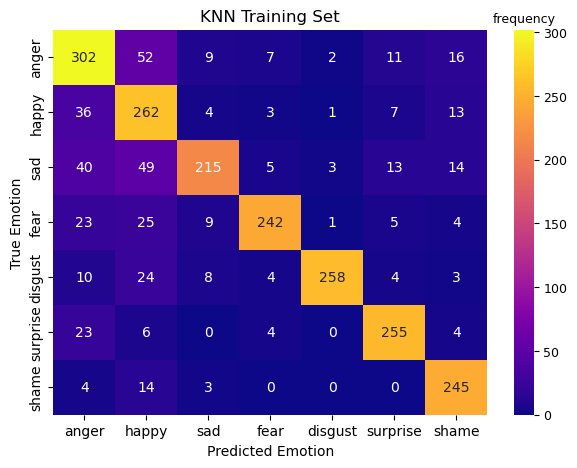

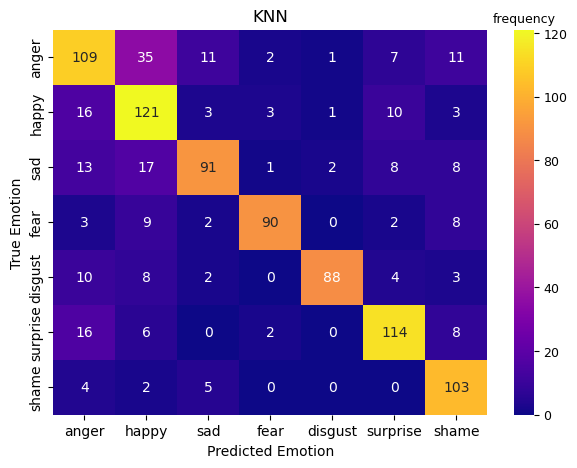

Mean CV Accuracy: 0.73

Training Set Overall Performance Metrics
Accuracy: 0.79
Precision: 0.81
Recall: 0.79
F1 Score: 0.80

Validation Set Overall Performance Metrics
Accuracy: 0.74
Precision: 0.76
Recall: 0.74
F1 Score: 0.75


In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

train_data = pd.read_csv("training_set.csv", names=["Emotion", "Text"], header=None)
val_data = pd.read_csv("validation_set.csv", names=["Emotion", "Text"], header=None)

train_data= train_data.dropna(subset=['Emotion', 'Text'])
val_data= val_data.dropna(subset=['Emotion', 'Text'])

label_mapping = {
    'anger': 1,
    'happy': 2,
    'sad': 0,
    'fear': 3,
    'disgust': 6,
    'surprise': 4,
    'shame':5
}


train_data = train_data[train_data['Emotion'].isin(label_mapping.keys())]

val_data = val_data[val_data['Emotion'].isin(label_mapping.keys())]


X_train = train_data['Text']
y_train = train_data['Emotion'].map(label_mapping)
X_val = val_data['Text']
y_val = val_data['Emotion'].map(label_mapping)

import re

def tokenization(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    return tokens


vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer=tokenization,
    stop_words="english",
    min_df=20,
    max_df=0.7,
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)




# training

kf = StratifiedKFold(n_splits=7)



knn = KNeighborsClassifier(n_neighbors=7, metric='cosine')  # Use cosine similarity for better results
cv_scores = cross_val_score(knn,X_train_tfidf, y_train, cv=kf, scoring='accuracy')

knn.fit(X_train_tfidf, y_train)

#test the model
y_pred_train = knn.predict(X_train_tfidf)
y_pred_val = knn.predict(X_val_tfidf)


print("Training Set Classification Report:")
print(classification_report(y_train, y_pred_train))

print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val))

train_cm = confusion_matrix(y_train, y_pred_train)
val_cm = confusion_matrix(y_val, y_pred_val)

print("Training Set Confusion Matrix:")
print(train_cm)

print("Validation Set Confusion Matrix:")
print(val_cm)


def calculate_tp_fp_tn_fn(conf_matrix, class_labels):
    metrics = {}
    for i, label in enumerate(class_labels):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        TN = np.sum(conf_matrix) - (TP + FP + FN)
        
        metrics[label] = {"TP": TP, "FP": FP, "TN": TN, "FN": FN}
    return metrics

# Get TP, FP, TN, FN for training and validation sets
train_metrics = calculate_tp_fp_tn_fn(train_cm, label_mapping.keys())
val_metrics = calculate_tp_fp_tn_fn(val_cm, label_mapping.keys())

print("\n=== Training Set TP, FP, TN, FN ===")
for emotion, values in train_metrics.items():
    print(f"{emotion}: TP={values['TP']}, FP={values['FP']}, TN={values['TN']}, FN={values['FN']}")

print("\n=== Validation Set TP, FP, TN, FN ===")
for emotion, values in val_metrics.items():
    print(f"{emotion}: TP={values['TP']}, FP={values['FP']}, TN={values['TN']}, FN={values['FN']}")


# training set confusion matrix
plt.figure(figsize=(7,5))
ax=sns.heatmap(train_cm, annot=True, fmt='d', cmap='plasma', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
colorbar = ax.collections[0].colorbar


colorbar.ax.set_title("frequency", fontsize=9, pad=5) 
colorbar.ax.tick_params(labelsize=9)


plt.title('KNN Training Set')
plt.xlabel('Predicted Emotion' )
plt.ylabel('True Emotion')
plt.show()

# validation set confusion matrix
plt.figure(figsize=(7, 5))
ax=sns.heatmap(val_cm, annot=True, fmt='d', cmap='plasma', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
colorbar = ax.collections[0].colorbar
#colorbar.ax.set_title("frequency")


colorbar.ax.set_title("frequency", fontsize=9, pad=5) 
colorbar.ax.tick_params(labelsize=9)


plt.title('KNN')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.show()

print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")


train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, average='weighted')
train_recall = recall_score(y_train, y_pred_train, average='weighted')
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

val_accuracy = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val, average='weighted')
val_recall = recall_score(y_val, y_pred_val, average='weighted')
val_f1 = f1_score(y_val, y_pred_val, average='weighted')


print("\nTraining Set Overall Performance Metrics")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"F1 Score: {train_f1:.2f}")

print("\nValidation Set Overall Performance Metrics")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Precision: {val_precision:.2f}")
print(f"Recall: {val_recall:.2f}")
print(f"F1 Score: {val_f1:.2f}")
